## Text Mining Project - TDDE16
### Juliana Gouveia de Sá Couto (julgo420)

## Research Question

This project tackles the task of using machine learning to distinguish between American and non-American movies based on their plots. The challenge goes beyond simple categorization; it delves into understanding cultural storytelling nuances embedded in movie narratives. The goal is not only to predict but also to unravel whether machines can grasp and differentiate the intricate storytelling styles that reflect diverse global cultures.

**Can machine learning models discern cultural storytelling patterns within movie plots, and if so, to what extent?**
Can machine learning models effectively identify cultural storytelling patterns in movie plots, specifically distinguishing between American and non-American narratives? This project explores the capabilities of various models in not just classifying movies but also in deciphering the cultural elements woven into their plots.

## 1. Libraries
The "Library" section includes crucial Python libraries like Pandas, NumPy, Spacy, and NLTK, forming the essential toolkit for text mining. This collection enables tasks from data manipulation and web scraping to advanced text analysis, providing a solid foundation for exploration. Matplotlib for visualization and Gensim for author topic modeling form an essential part of the text mining toolkit.

In [2]:
# Main libraries
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from collections import defaultdict, Counter
import re
import string                             
import nltk
nltk.download('stopwords')

import random

# For collocations
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

# For TF_IDF Analysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# For web scraping
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

# For dimensionality reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import sklearn.manifold

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

# For word embedding and document embedding
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import numpy as np

# For clustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering

# For topic modeling
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel, Word2Vec
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases

import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

# For author topic modeling
from gensim.models import AuthorTopicModel
from gensim.test.utils import datapath, temporary_file

from tqdm.notebook import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Data

The "Data" section involves loading a dataset from the 'wiki_movie_plots_deduped.csv' file into a Pandas DataFrame. This dataset comprises plot summaries scraped from Wikipedia, spanning 34,886 movies globally. Key attributes include release year, movie title, origin or ethnicity, director(s), main actors and actresses, movie genre(s), Wikipedia page URL, and a detailed plot description. This rich dataset serves as the basis for applications like content-based movie recommendation, movie plot generation, information retrieval, and text classification.

In [ ]:
df = pd.read_csv('Data/wiki_movie_plots_deduped.csv')

In [ ]:
df.head()

## 3. Scraping for label annotation

In the "Scraping for Label Annotation" section, a Python script is utilized to extract movie durations from Wikipedia pages. The function get_duration is defined to fetch the running time information from a given Wikipedia URL. The script then iterates through the dataset's 'Wiki Page' column, scraping and storing the durations in a new column named 'durations.' After dropping observations without duration information, the script extracts numerical representations of durations in minutes using regular expressions. The resulting 'minutes' column is added to the dataset, and non-numeric or missing values are further removed. The final DataFrame provides a labeled dataset ready for subsequent analysis and modeling.

In [ ]:
# Function to get duration from wiki page
def get_duration(wiki_url):
    src = requests.get(wiki_url).text
    soup = BeautifulSoup(src, 'lxml')
    all_boxes = soup.find_all("th", class_="infobox-label")
    minu = None
    for i, el in enumerate(all_boxes):
        if el.text == 'Running time':
            minu = soup.find_all("td", class_="infobox-data")[i].text
    return minu

In [ ]:
# Scrape durations
durations = []

for t in tqdm(df['Wiki Page']):
    durations.append(get_duration(t))

In [ ]:
# Set scraped durations as a column in the dataset
df['durations'] = durations

# Drop observations with no duration
df = df.dropna(subset = ['durations']).copy()
df.head()

In [ ]:
# Patterns to retrieve the number of minutes
pattern = r"([0-9]+)\+* *-*(\xa0)*(\n)*[M-m]in[utes]*"
pattern2 = r"([0-9])+:[0-9]+"

# Save the numbers retrieved in a list
minutes = []
for el in df.durations:
    m = re.search(pattern, el)
    if m != None:
        m = m[1]
    else:
        m = re.search(pattern2, el)
        if m != None:
            m = m[1]
    minutes.append(m)

In [ ]:
# Set the duration in minutes as a column of the df
df['minutes'] = minutes

# Drop observations with no duration in minutes
df = df.dropna(subset = ['minutes'])

# Reset index and change to proper type
df = df.reset_index(drop = True).astype({'minutes':int})

# Drop the column duration
df = df.drop(columns = 'durations')

df.head()

In [ ]:
# Uncomment and run to load cleaned dataframe without running
# df = pd.read_csv("Data/wiki_movie_plots_clean.csv")

## 4. Data preprocessing
This section focuses on preparing the movie plot data for subsequent analysis. The raw movie plot text undergoes a series of transformations, starting with lower-casing, removal of numbers, punctuation, and stop words, and lemmatization to reduce variability. Collocations, representing meaningful word combinations, are incorporated to enhance the accuracy of subsequent analyses. Additionally, proper nouns are identified and removed using POS tagging from the spaCy library. This step is crucial for mitigating bias in topic modeling, ensuring that proper names do not disproportionately influence the analysis, and preserving the plot's indicative nature.

In [ ]:
# Define a preprocess function
def preprocess(input_text):
    
    # Normalize to lowercase
    txt = input_text.lower()
    
    # Remove numbers
    txt = re.sub(r"\d", "", txt)
    
    # Remove punctuation
    txt = re.sub('\n', '', txt)
    txt = re.sub(r"[^A-Za-z]+", " ", txt)  
    
    # Remove stopwords
    stop_words = [w.lower() for w in stopwords.words()]
    txt = ' '.join([w for w in txt.split() if len(w) >  2 and w not in stop_words])
    
    # Lemmatization
    lemmas = [token.lemma_ for token in nlp(txt)]
    txt = " ".join(lemmas)
    
    return txt

In [ ]:
# Tokenizer function
def tokenizer(text):
    
    # Lower casing
    txt = text.lower()
    
    # Number removal
    txt = re.sub(r"\d", "", txt)
    
    # Punctuation removal
    txt = re.sub('\n', '', txt)
    txt = re.sub(r"[^A-Za-z]+", " ", txt) 
    
    return txt

In [ ]:
%time clean_plot = [preprocess(string) for string in tqdm(df.Plot)]

In [ ]:
# Putting the preprocessed text in the dataset
df["plot_cleaned"] = clean_plot

In [ ]:
# Putting the lemmatized documents in the dataset
lemmas = [lemma.split() for lemma in clean_plot]
df['lemmas'] = lemmas

In [ ]:
# Tokenization applied to the plots
tokens = [[token.text for token in nlp(sentence)]
          for sentence in tqdm([tokenizer(el) for el in df.Plot])]

In [ ]:
# Putting the tokenized documents in the dataset
df['tokens'] = tokens

In [ ]:
df.plot_cleaned[0]

### 4.1. Find and replace collocations
Collocations (meaningful word combinations) in the movie plots are identified and replaced to enhance the accuracy of subsequent analyses. A scoring threshold is set for collocations, and the modified plots are added to the DataFrame.

In [ ]:
words = [word for document in clean_plot for word in document.split()]

In [ ]:
finder = BigramCollocationFinder.from_words(words) 
bgm = BigramAssocMeasures() 
score = bgm.mi_like 
 
# I choose 4 as threshold for collocations as I notice that the majority of them were actually accurate and refered to actors' names
collocations = set({" ".join(bigram): scoring for bigram, scoring in finder.score_ngrams(score) if scoring >= 4})

In [ ]:
def replace_collocations(s):
    s = s.split()
    i = 0
    while i <= len(s) - 2:
        if str(s[i] + " " + s[i+1]) in collocations:
            s[i] = s[i] + "_" + s.pop(i+1)
        i += 1
    s = " ".join(s)
    return s

final_plot = [replace_collocations(string) for string in clean_plot]

In [ ]:
df['plot_cleaned'] = final_plot

### 4.2. Statistics before and after preprocessing
The statistical impact of preprocessing is assessed, comparing token and type counts in the movie plots before and after the cleaning steps. The number of documents, tokens, and types are presented for both the original and cleaned datasets.

In [ ]:
# Transforming the movie plots column in a list of strings
documents = df["Plot"].tolist()

# Collecting statistics before preprocessing
tokens_bef = [word for document in documents for word in document.split() ]
types_bef = set([word for document in documents for word in document.split() ])

# Transforming the movie cleaned plots column in a list of strings
c_plot = df["plot_cleaned"].tolist()

# Collecting statistics after preprocessing
words_aft = [word for document in c_plot for word in document.split() ]
types_aft = set(words_aft)

print("The number of documents before preprocessing was:", len(documents))
print("The number of tokens before preprocessing was:", len(tokens_bef))
print("The number of types before preprocessing was:", len(types_bef) )
print("*"*60)

print("The number of documents after preprocessing is:", len(clean_plot))
print("The number of tokens after preprocessing is:", len(words_aft))
print("The number of types after preprocessing is:", len(types_aft) )

### 4.3. Add target binary variables
Binary target variables, 'american' and 'is_long,' are created based on the movie's origin and duration, respectively. This step is crucial for subsequent classification tasks.

In [ ]:
# Two binary target variables creation
df['american'] = [1 if origin == 'American' else 0 for origin in df['Origin/Ethnicity']]
df['is_long'] = [1 if minute >= 100 else 0 for minute in df['minutes']]

In [ ]:
df.head()

### 4.4. Split into train, dev, test sets
The dataset is split into training, development, and test sets. The sets are created with proportions of 70%, 15%, and 15%, respectively. Furthermore, proper nouns are removed from the training set, ensuring that potential biases introduced by names are mitigated. The resulting datasets are then saved for future use in the analysis pipeline.

In [ ]:
rand = 22

# Create training set
train = df.sample(frac=0.7,random_state = rand) 
not_train = df.drop(train.index)

# Create development set
dev = not_train.sample(frac = 0.5, random_state = rand)

# Create test set
test = not_train.drop(dev.index)

# Reset indexes of all
train.reset_index(drop = True, inplace = True)
dev.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

In [ ]:
clean_plot = train["plot_cleaned"].tolist()

no_names = []
for plot in clean_plot:
    plot_split = plot.split()
    
    for token in nlp(plot):
        if token.pos_ =="PROPN":
             
            if token.text in plot_split:
                plot_split.remove(token.text)
    no_names.append(' '.join(plot_split))

In [3]:
# Uncomment and run to load cleaned dataframe without running
# df = pd.read_csv("Data/wiki_movie_plots_preprocess.csv")

# train = pd.read_csv("Data/wiki_movie_plots_train.csv")
# dev = pd.read_csv("Data/wiki_movie_plots_dev.csv")
# test = pd.read_csv("Data/wiki_movie_plots_test.csv")

## 5. EDA - Exploratory Data Analysis
The exploration begins by examining the overall trend in movie releases worldwide over the years. A new column has been introduced to the dataset, explicitly indicating the countries corresponding to diverse ethnicities, enhancing the understanding of the variable 'origin.' Additionally, there is an analysis of the 'duration' variable, involving the transformation of the movie cleaned plots column into a list of strings.

### 5.1. Number of movies over the years

In [4]:
print("The total number of movies is:", len(df))

The total number of movies is: 29580


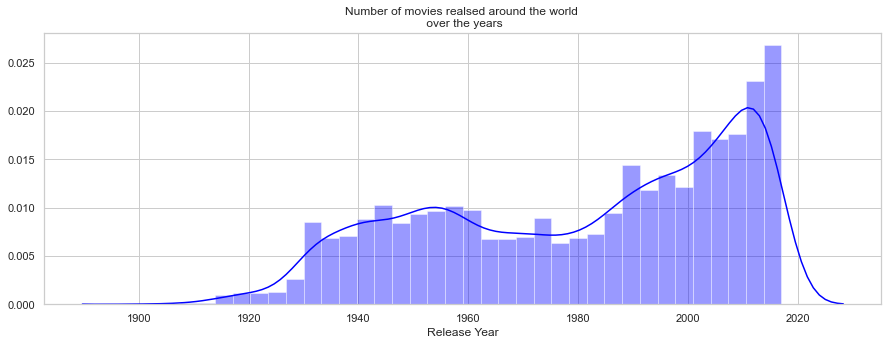

In [28]:
# First, let's see the overall trend in the movie production industry over a century.
# Check out the overall trend in movie releases over the years around the world 
plt.figure(figsize=(15, 5))

sns.distplot(a=df["Release Year"], color='blue')
plt.title("Number of movies realsed around the world \n over the years", loc="center")

plt.show()

### 5.2. Variable 'duration' analysis
A comprehensive analysis of movie duration statistics, including a histogram and a dummy variable for long and short durations, provides insights into the distribution of movie lengths. This examination aids in understanding the overall landscape of movie durations in the dataset.

In [11]:
df["minutes"].describe()

count    29580.000000
mean       104.794050
std         34.344107
min          0.000000
25%         87.000000
50%        100.000000
75%        120.000000
max       1949.000000
Name: minutes, dtype: float64

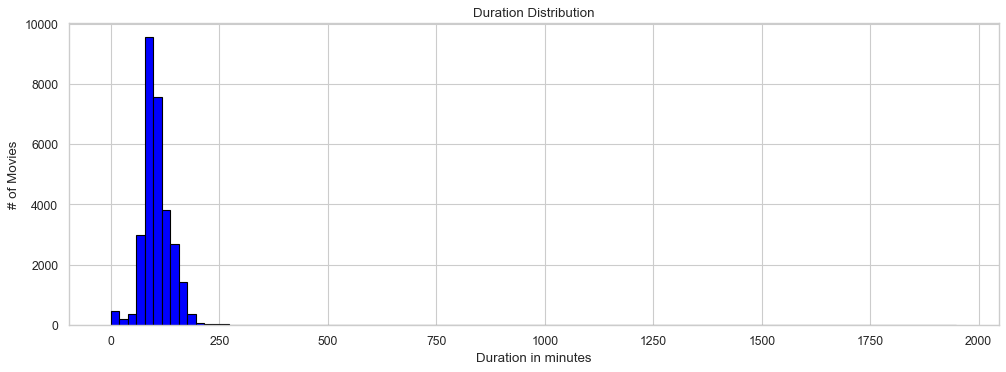

In [26]:
sns.set_context("notebook")

plt.figure(figsize=(15, 5), dpi=80)
plt.hist(df['minutes'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Duration in minutes')
plt.ylabel('# of Movies')
plt.title('Duration Distribution')

plt.savefig("duration_distribution.jpg")

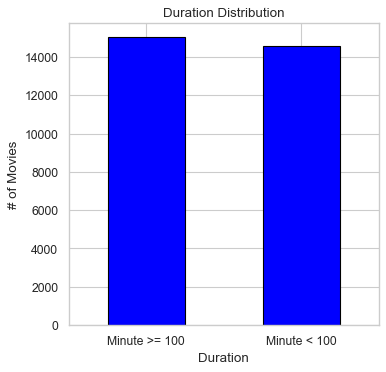

In [42]:
# Dummy variable on duration
sns.set_context("notebook")

plt.figure(figsize=(5, 5), dpi=80)
df['is_long'].value_counts().plot(kind='bar',color='blue', edgecolor='black')
plt.xticks([0, 1], ['Minute >= 100', 'Minute < 100'], rotation=0)
plt.xlabel('Duration')
plt.ylabel('# of Movies')
plt.title('Duration Distribution')

plt.savefig("duration_distribution1.jpg")

### 5.3. Variable 'origin' analysis

In [18]:
df.rename(columns = {'Origin/Ethnicity':'origin'}, inplace = True)

In [19]:
# Types of Origin 
print("The number of different origins are: ", df.origin.nunique())
print("**********************************************************")
print("The different origins are:")
df["origin"].value_counts()

The number of different origins are:  24
**********************************************************
The different origins are:


American        16270
British          3343
Bollywood        1896
Tamil            1812
Japanese          974
Telugu            893
Hong Kong         684
Canadian          655
Malayalam         535
Australian        510
South_Korean      466
Chinese           414
Kannada           322
Russian           211
Bengali           182
Filipino          108
Marathi            70
Malaysian          57
Bangladeshi        57
Turkish            50
Punjabi            35
Egyptian           32
Assamese            3
Maldivian           1
Name: origin, dtype: int64

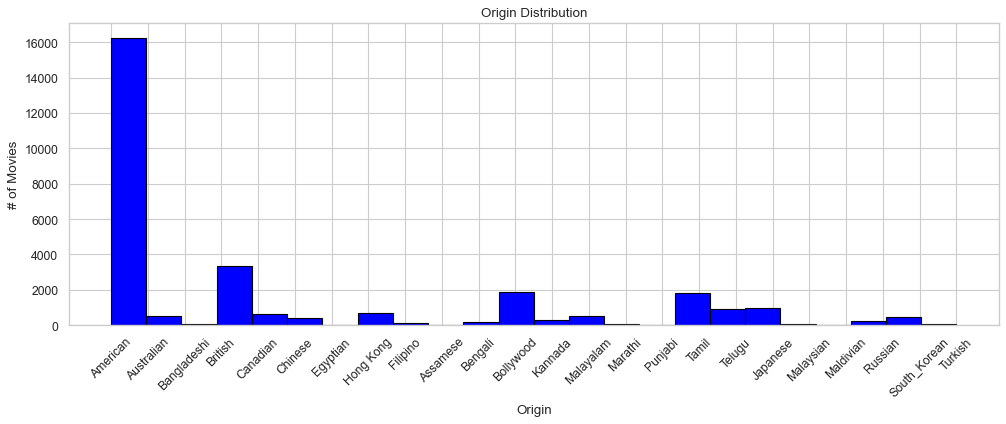

In [25]:
sns.set_context("notebook")
plt.figure(figsize=(15, 5), dpi=80)

plt.hist(df['origin'],bins=df.origin.nunique(), color='blue', edgecolor='black')
plt.xlabel('Origin')
plt.ylabel('# of Movies')
plt.title('Origin Distribution')
plt.xticks(rotation = 45)

plt.savefig("origin_distribution1.jpg")

In conclusion, the exploration of the movie dataset reveals a notable dominance of American movies, with a diverse range of ethnicities and origins represented. That said, among the 24 origins documented in the dataframe, the United States emerges as the unequivocal leader in movie production. 

A noteworthy observation is the substantial presence of ethnicities from India, prompting a pragmatic step forward in simplifying the analysis. To facilitate further examination and comprehension, a new column has been added to the dataframe, explicitly denoting the countries corresponding to these diverse ethnicities. This strategic augmentation lays the groundwork for a more streamlined and insightful analysis of the dataset.

In [30]:
equiv_dict = {"American":"The US", "Australian":"Australia", "Bangladeshi":"Bangladesh", 
              "British":"The Great Britain", "Canadian":"Canada", "Chinese":"China", 
              "Egyptian":"Egypt", "Hong Kong":"Hong Kong", "Fillipino":"The Phillipins", 
              "Assamese":"India", "Bengali":"India", "Bollywood":"India", "Kannada":"India", 
              "Malayalam":"India", "Marathi":"India", "Punjabi":"India", "Tamil":"India", 
              "Telugu":"India", "Japanese":"Japan", "Malaysian":"Malaysia", "Maldivian":"Maldives", 
              "Russian":"Russia", "South_Korean":"South_Korea","Turkish":"Turkey"}

df['country'] = df['origin'].map(equiv_dict)

In [31]:
# Types of Country 
print("The number of different countries is: ", df.country.nunique())
print("**********************************************************")
print("The different countries are:")
df["country"].value_counts()

The number of different countries is:  15
**********************************************************
The different countries are:


The US               16270
India                 5748
The Great Britain     3343
Japan                  974
Hong Kong              684
Canada                 655
Australia              510
South_Korea            466
China                  414
Russia                 211
Bangladesh              57
Malaysia                57
Turkey                  50
Egypt                   32
Maldives                 1
Name: country, dtype: int64

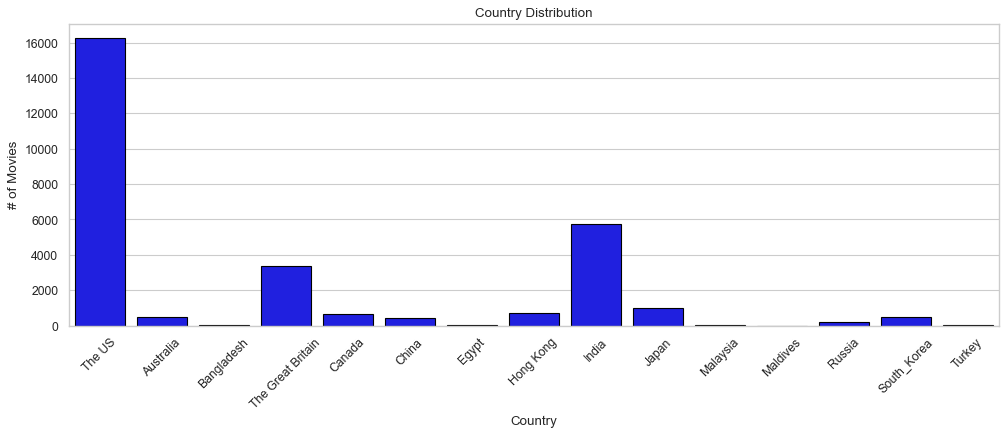

In [34]:
sns.set_context("notebook")

plt.figure(figsize=(15, 5), dpi=80)
sns.countplot(x='country', data=df, color='blue', edgecolor='black')
plt.xlabel('Country')
plt.ylabel('# of Movies')
plt.title('Country Distribution')
plt.xticks(rotation = 45)

plt.savefig("country_distribution1.jpg")

By consolidating similar ethnicities into broader country categories, the data analysis becomes more manageable with a reduced number of distinct groups. The examination reveals that India secures the second position in movie production, generating approximately half the number of movies produced by the United States over the century. 

Following closely are Great Britain and Japan, both exhibiting considerably lower movie production compared to the leading two nations. This categorization enhances the clarity of comparative insights into the cinematic contributions of different countries.

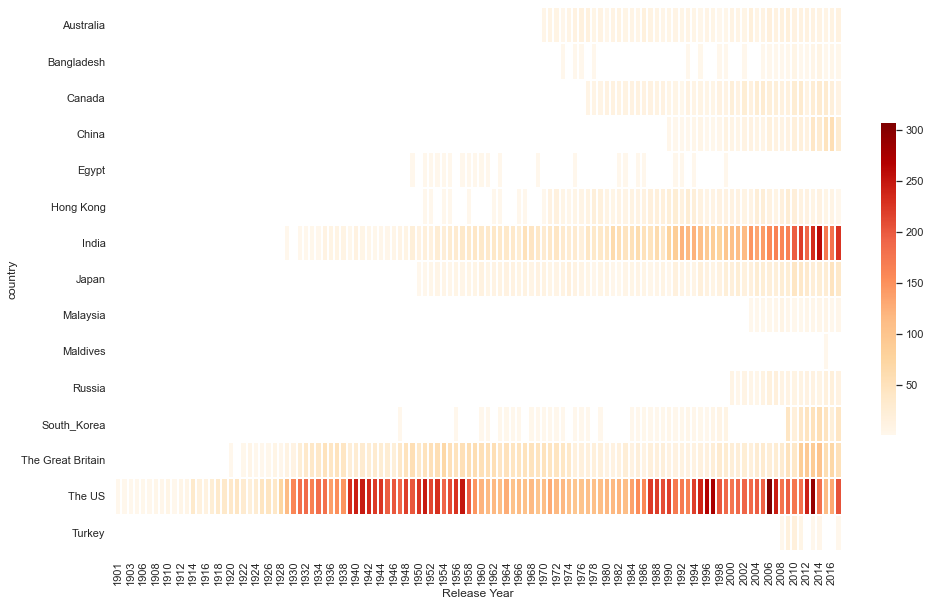

In [35]:
# Group the data by the "Country" and "Release Year" columns 
# to make visual the periods when the movie production was the most intensive for different countries.
by_country_by_year = df.groupby(["country","Release Year"]).size().unstack()

plt.figure(figsize=(14,10))
g = sns.heatmap(
    by_country_by_year, 
    #square=True, # make cells square
    cbar_kws={'fraction' : 0.02}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

Grouping the data by country and release year, a heatmap visualizes periods of intensive movie production for different countries. The exploration also highlights the dominance of American movies, underscoring the United States as a leader in the global movie industry.

In [39]:
df["american"].value_counts()

1    16270
0    13310
Name: american, dtype: int64

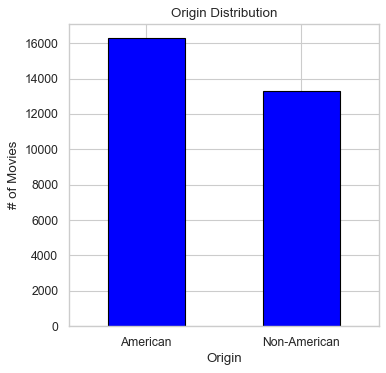

In [43]:
sns.set_context("notebook")
plt.figure(figsize=(5, 5), dpi=80)

df['american'].value_counts().plot(kind='bar',color='blue', edgecolor='black')
plt.xticks([0, 1], ['American', 'Non-American'], rotation=0)
plt.xlabel('Origin')
plt.ylabel('# of Movies')
plt.title('Origin Distribution')

plt.savefig("origin_distribution.jpg")

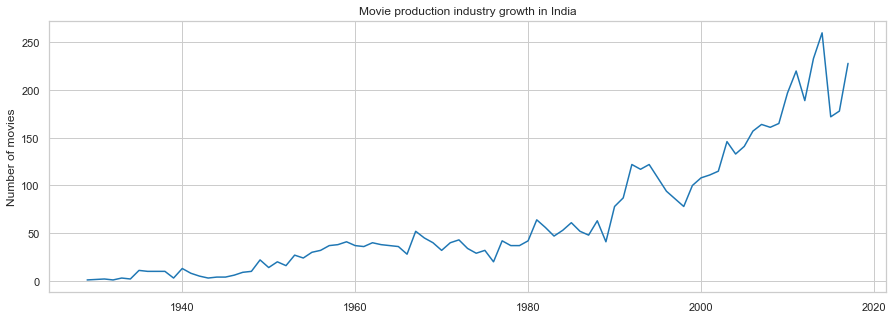

In [38]:
india = df[["country", "Release Year"]].query('country == "India" ').groupby("Release Year").size()

plt.figure(figsize=(15,5))

plt.title("Movie production industry growth in India")
plt.ylabel("Number of movies")
sns.lineplot(data=india)

plt.show()

### The USA
Analysis of the leading countries in movie production reveals that the United States, India, the United Kingdom, and Japan initiated their cinematic attempts much earlier than many other nations, contributing to the significant variations in production numbers. In the case of the United States, the movie industry demonstrated progressive growth until the 1960s, followed by a two-decade decline, a phenomenon attributed to the advent of television and shifts in audience demographics, leading to the transition from "Old Hollywood" to "New Hollywood." The subsequent recovery can be linked to the beggining of the digital age, enabling faster and more cost-effective movie production.

### India
Turning our attention to the Indian movie industry, a steady growth trajectory was observed until the 1980s, marked by a temporary stagnation caused by factors such as rising violence, declining musical quality, and increased video piracy. The pivotal moment arrived with the release of the musical romance "Chandni" in 1989, breaking the trend of violent action films and rejuvenating the romantic musical genre. This shift, outlined in the context of "New Bollywood," set a new standard for Hindi cinema. From the 2000s onward, the Indian film production industry experienced accelerated growth, potentially influenced by the expanding population of India and the transformative impact of the digital age on production efficiency.

### 5.3. Preprocessing summary

In [44]:
# Transforming the movie cleaned plots column in a list of strings
cleaned_plot = df["plot_cleaned"].tolist()
df["new"]= cleaned_plot

In [45]:
df.head()

,Release Year,Title,origin,Director,Cast,Genre,Wiki Page,Plot,minutes,plot_cleaned,lemmas,tokens,american,is_long,country,new
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",1,bartender work saloon serve drink customer fil...,"['bartender', 'work', 'saloon', 'serve', 'drin...","['a', 'bartender', 'is', 'working', 'at', 'a',...",1,0,The US,bartender work saloon serve drink customer fil...
1,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",1,film minute long compose shot girl sit base al...,"['film', 'minute', 'long', 'compose', 'shot', ...","['the', 'film', 'just', 'over', 'a', 'minute',...",1,0,The US,film minute long compose shot girl sit base al...
2,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,10,early adaptation classic fairytale film show j...,"['early', 'adaptation', 'classic', 'fairytale'...","['the', 'earliest', 'known', 'adaptation', 'of...",1,0,The US,early adaptation classic fairytale film show j...
3,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab...",19,alice large white rabbit rabbit hole find tiny...,"['alice', 'large', 'white', 'rabbit', 'rabbit'...","['alice', 'follows', 'a', 'large', 'white', 'r...",1,0,The US,alice large white rabbit rabbit hole find tiny...
4,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,12,film open bandit break railroad telegraph offi...,"['film', 'open', 'bandit', 'break', 'railroad'...","['the', 'film', 'opens', 'with', 'two', 'bandi...",1,0,The US,film open bandit break railroad telegraph offi...


### 5.4. Topic Model

The provided code snippet initiates a comprehensive topic modeling analysis on a movie dataset, discerning themes that distinguish American and non-American films. Following meticulous data preprocessing, including tokenization and bigram identification, the script utilizes Latent Dirichlet Allocation (LDA) for topic modeling. 

Through iterative evaluation of different topic numbers, the script employs two coherence metrics, UMass and C_V, to gauge the quality of topics. The visualization of coherence scores guides the selection of the optimal number of topics (4) by striking a balance between UMass and C_V scores, a decision supported by correlation analysis - the higher the scores, the more coherent and interpretable the topics are. 

The subsequent training of the LDA model and extraction of topic descriptors provide nuanced insights into the prevalent themes characterizing the two classes of movies (American and Non-American), offering a refined understanding of their thematic compositions.

In [97]:
train['no_names'] = train['no_names'].astype(str)
instances = train['no_names'].apply(str.split).tolist()

# read in instances and create Dictionary object with information about frequencies etc. 
phrases = Phrases(instances, min_count=3, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=50, no_above=0.3)

In [98]:
# Replace words by their numerical IDs and their frequency
# Translating corpus to IDs
ldacorpus = [dictionary.doc2bow(text) for text in instances]

# Learning TFIDF values from corpus - tf-idf transformation
tfidfmodel = TfidfModel(ldacorpus)

# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

In [99]:
coherence_values = []

for num_topics in range(2, 7):

    model = LdaMulticore(corpus=model_corpus[:len(dev)], id2word=dictionary, num_topics=num_topics, random_state=15)

    coherencemodel_umass = CoherenceModel(model=model, texts=instances[:len(dev)], dictionary=dictionary, coherence='u_mass')
    coherencemodel_cv = CoherenceModel(model=model, texts=instances[:len(dev)], dictionary=dictionary, coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()

    coherence_values.append((num_topics, umass_score, cv_score))

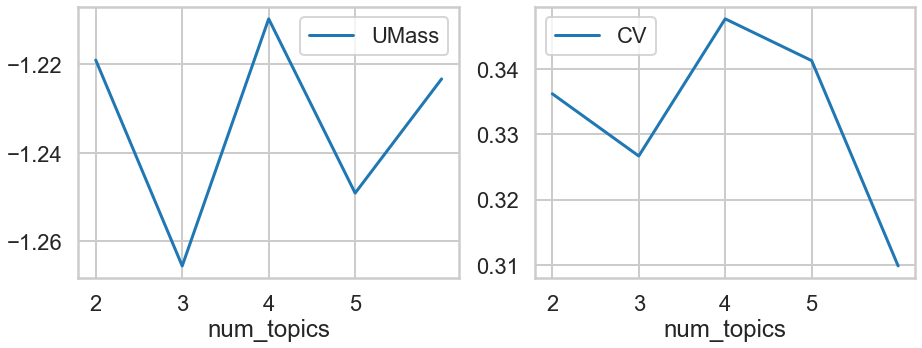

In [100]:
%matplotlib inline

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(2,6))
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(2,6))

plt.show()

In [101]:
scores.corr()

,num_topics,UMass,CV
num_topics,1.000000,0.054139,-0.409182
UMass,0.054139,1.000000,0.170564
CV,-0.409182,0.170564,1.000000


In [102]:
num_topics = 4

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, corpus=model_corpus, id2word=dictionary,workers=13, passes=num_passes, chunksize=chunk_size,
                      alpha=0.4, random_state=15
                    )
    
print("done in {}".format(time.time()-start), flush=True)

1035.3
fitting model
done in 185.9462766647339


In [103]:
# transform the data into topic distros
topic_corpus = model[model_corpus]

topic_corpus[0]

[(0, 0.31047165), (1, 0.0674585), (2, 0.42928848), (3, 0.1927814)]

In [108]:
# get the topic descriptions
topic_sep = re.compile("0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=15)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:7]))
    descriptors.append(", ".join(m[:5]).replace('"', ''))

1 "fly", "film", "begin", "bug", "school", "earth", "body"
2 "ship", "german", "soldier", "kill", "king", "capture", "crew"
3 "family", "marry", "love", "film", "marriage", "mother", "story"
4 "police", "kill", "murder", "money", "car", "gang", "crime"


In [109]:
descriptors

['fly, film, begin, bug, school',
 'ship, german, soldier, kill, king',
 'family, marry, love, film, marriage',
 'police, kill, murder, money, car']

In [110]:
americano = train["american"].tolist()

In [111]:
for i in range(len(americano)):
    if americano[i]==1:
        americano[i]="american"
    else:
        americano[i]="other"


In [112]:
limit = len(train)

# get a list with the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(limit)]

# turn that into a data frame with N rows and K columns, 
# each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)

# add the review category of each document as column (so we can aggregate)
topic_distros['american'] = americano

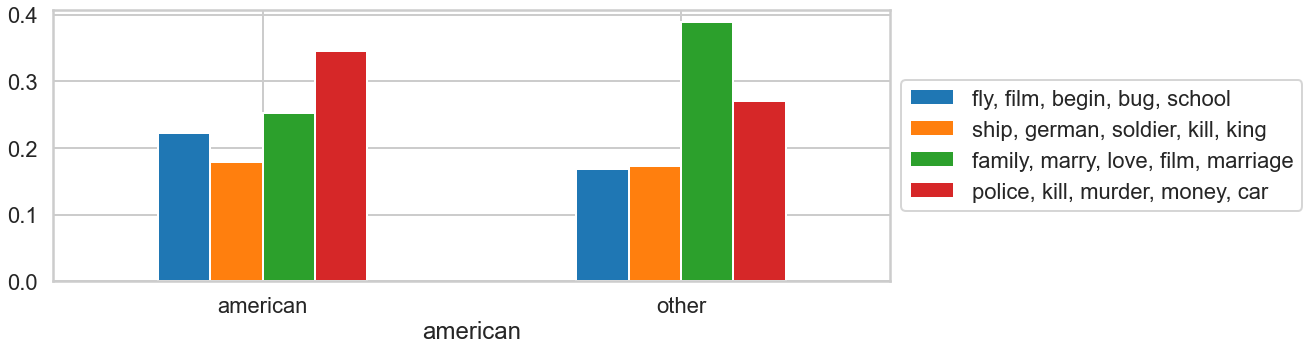

In [113]:
#Topic model in American and non-American movies
sns.set_context('poster') # use large font
fig, ax = plt.subplots(figsize=(15, 5)) # set graph size

# aggregate topics by categories
aggregate_by_category = topic_distros[topic_distros.american.isin('american other'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.american).mean()

# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax)

# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.savefig("am_topic.jpg")

In the exploration of American and non-American movies through a topic modeling approach, it became evident that these two categories exhibit distinct thematic preferences. Analyzing the distribution of topics revealed that American movies are prominently associated with themes related to crime (topic 4) and action (topic 2). Conversely, non-American films tend to focus more on themes of love and family (topic 3). The first topic appears to be linked to sports and nations, with minimal differentiation between the two classes.

### 5.5. Document embedding

The document embedding technique, specifically the Doc2Vec model, is explored to assess its suitability as an input for a classification task. The goal is to determine if the matrix of embedded documents holds meaningful information for the subsequent classification. In other words, The primary objective is to assess whether the matrix of embedded documents derived from the Doc2Vec model could serve as a viable input for a classification task. 

In this analysis, the focus is on evaluating the clusters generated by the Doc2Vec model concerning movie duration and origin. It involves training the model on a corpus of movie plots and visualizing the resulting document matrix through dimensionality reduction. The outcome of this assessment informs the decision to concentrate solely on the TFIDF matrix for subsequent steps.

In [144]:
corpus = []

for i, plot in enumerate(train.plot_cleaned):
    corpus.append(TaggedDocument(words=plot, tags=[i]))

In [145]:
model = Doc2Vec(vector_size=100, window=15, hs=0, sample=0.00001, negative=5, min_count=100, workers=-1,
                epochs=500, dm=0, dbow_words=1, seed=i)

model.build_vocab(corpus)

# train the model
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

# build the matrix
doc_matrix = pd.DataFrame([model.dv[n] for n in range(len(model.dv.index_to_key))], 
                             index = model.dv.index_to_key)

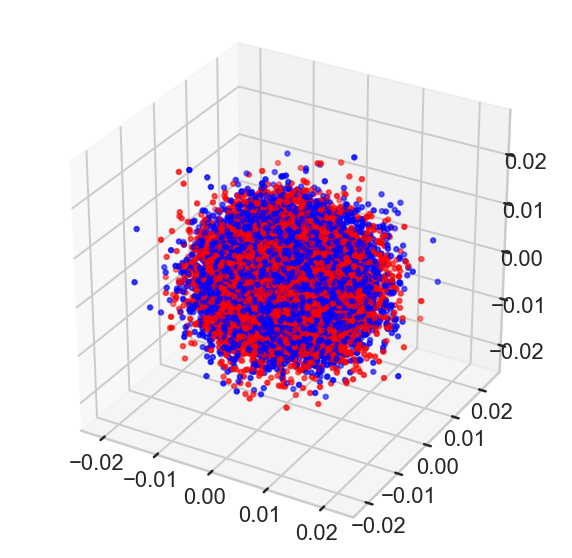

In [148]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
doc_matrix_reduced = pca.fit_transform(doc_matrix)

colors = ['r' if el == 0 else 'b' for el in train.is_long]
          
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

dx = doc_matrix_reduced[:,0]
dy = doc_matrix_reduced[:,1]
dz = doc_matrix_reduced[:,2]

ax.scatter(dx,dy,dz, color = colors)
    
plt.show()

The Doc2Vec model is trained on a corpus of movie plots, and the resulting document matrix is subjected to dimensionality reduction using Principal Component Analysis (PCA). However, the visualization of the reduced matrix does not reveal distinct clusters based on movie duration or origin. Consequently, the decision is made to not employing the use of the Doc2Vec matrix for the classification task and instead prioritize the TFIDF matrix in the subsequent stages of the analysis.

## 6. Classification task - American VS non-American movies

The classification task focuses on the challenge of differentiating between American and non-American movies using various machine learning models. This analysis explores Most Frequent Label Heuristic, Logistic Regression, Support Vector Machines (SVM), Random Forest, and Convolutional Neural Network (CNN) models to discern distinct storytelling patterns indicative of cultural origins within movie plots. The primary objective is to achieve predictive accuracy while gaining insights into narrative elements that might serve as cultural identifiers. 

The F1-micro score is employed as a guiding metric. This quantitative measure (F1 score micro) provides a single aggregate measure of precision and recall for the entire classification task, treating all classes equally. It is suitable for imbalanced datasets just like this case, where 16270 movies are American and the remaining 13310 are non-American.

In [4]:
# create the y's vectors
y_train = train['american']
y_dev = dev['american']
y_test = test['american']

# create dictionary to store scores
test_scores = {}

### 6.1 Most frequent label baseline <a name="mfb"></a>

The Most Frequent Label Baseline serves as a simple yet fundamental benchmark in classification tasks. In this context, it represents a baseline model that predicts the movie category based on the most frequent class observed in the training data. This approach assumes that the majority class in the training set is a reasonable initial estimate for any given instance, making it a straightforward method for establishing a baseline performance level.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF matrix with 2-6 gram character.
# In the future, it will be uses as the estimators' design matrix.
vectorizer = TfidfVectorizer(ngram_range=(2,6), min_df=0.001, max_df=0.7, analyzer='char', sublinear_tf=True                            )

X_train = vectorizer.fit_transform(train['plot_cleaned'])
print(X_train.shape)

(20706, 286636)


In [6]:
X_dev = vectorizer.transform(dev['plot_cleaned'])
X_test = vectorizer.transform(test['plot_cleaned'])
print(X_dev.shape, X_test.shape)

(4437, 286636) (4437, 286636)


In [7]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

# find the most frequent class in the training data
most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, y_train)

# storing the predictions for bootstrap significant sampling
baseline1 = most_frequent.predict(X_test)

# get the performance on the development set
dumb_predictions = most_frequent.predict(X_dev)
print(classification_report(y_dev, dumb_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2038
           1       0.54      1.00      0.70      2399

    accuracy                           0.54      4437
   macro avg       0.27      0.50      0.35      4437
weighted avg       0.29      0.54      0.38      4437



c:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
from sklearn.metrics import f1_score
print(f1_score(y_dev, dumb_predictions, average='micro'))

# storing the performance
test_scores['Most frequent label predictor'] = f1_score(y_test, baseline1, average='micro')

The F1 score micro of 0.544, falling within the range of 0 to 1, indicates the model's ability to balance precision and recall for the given classification task. In binary classification, where 0 represents poor performance and 1 represents perfect performance, the obtained F1 score suggests a moderate level of effectiveness. 

While there is no strict rule for an acceptable range of F1 scores, values above 0.5 are commonly considered indicative of a reasonably effective model, with a precision score above 0.5 suggesting a relatively low rate of false positives. However, further exploration and comparison with alternative models will be conducted, aiming to provide insights into the relative performance of the baseline model within this specific context.

### 6.2 Logistic 2-6 gram characters baseline <a name="lcb"></a>

In this approach, the TFIDF matrix is constructed using character n-grams (2-6 gram characters) as features. Logistic regression is then applied to this matrix as a classification model. The logistic regression algorithm aims to find the best-fitting logistic curve to predict the probability of a binary outcome, in this case, whether a movie is American or non-American. The model is trained on the training set and evaluated on the development set, providing a baseline performance for subsequent comparisons and improvements.

In [9]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [10]:
# storing the predictions for bootstrap significant sampling
baseline2 = classifier.predict(X_test)

# get the performance on the development set
predictions = classifier.predict(X_dev)
print(classification_report(y_dev, predictions))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      2038
           1       0.82      0.94      0.88      2399

    accuracy                           0.86      4437
   macro avg       0.87      0.85      0.85      4437
weighted avg       0.86      0.86      0.86      4437



In [11]:
print(f1_score(y_dev, predictions, average='micro'))

# storing the performance
test_scores['Logistic 2-6 char grams'] = f1_score(y_test, baseline2, average='micro')

0.8580121703853956


The second baseline F1 score (0.858) for the Logistic Regression with 2-6 gram characters significantly outperforms the first baseline F1 score (0.544) achieved by the Most Frequent Label predictor. This notable difference highlights the effectiveness of the logistic regression model in capturing patterns within the given data compared to a simplistic approach that predicts all observations with the most frequent class label.

### 6.2.1 Logistic baseline parameter tunning

The second baseline's improvement includes adjusting parameters for a logistic regression model using 2-6 gram characters. Different regularization methods ('elasticnet', 'l1', 'l2', and 'none') are tested. The 'saga' solver, capable of handling various penalties and elastic net mixing ratios, is employed. The code runs through each regularization technique to find the most effective one.

- <u>elasticnet</U>: combines both L1 (Lasso) and L2 (Ridge) penalties in the regularization term. 

- <u>l1</u>: also known as Lasso regularization, adds the absolute values of the coefficients as a penalty term to the loss function. It tends to produce sparse weight vectors, effectively setting some coefficients to exactly zero.

- <u>l2</u>: also known as Ridge regularization, adds the sum of squared coefficients as a penalty term to the loss function. It helps prevent overfitting and tends to distribute the weight among all features.

- <u>none</u>: This option implies no regularization. The model is trained without any penalty term on the coefficients, making it more prone to overfitting, especially when dealing with a large number of features.

In [12]:
regs = ['elasticnet', 'l1', 'l2', 'none']
scores = []
ratio = None

for reg in regs:
    if reg == 'elasticnet':
        ratio = 0.5
    classifier = LogisticRegression(solver = 'saga', penalty = reg, l1_ratio = ratio)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_dev)
    scores.append(f1_score(y_dev, predictions, average='micro'))

c:\Users\julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\julia\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
c:\Users\julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\j

In [13]:
scores

[0.8435880099166103, 0.8350236646382692, 0.8580121703853956, 0.86342123056119]

The last regression without any special adjustments ('none') showed a tiny increase, only by 0.006, in the F1 score compared to the baseline. Since the baseline already used L2 regularization as a default setting, this small difference is considered not significant from a statistical point of view.

In [14]:
# compute the predictions with the selected model 
classifier = LogisticRegression(penalty = 'none')
classifier.fit(X_train, y_train)

logistic_none = classifier.predict(X_test)

f1_score(y_test, logistic_none, average='micro')

# storing the performance
test_scores['Logistic 2-6 char grams (no reg.)'] = f1_score(y_test, logistic_none, average='micro')

c:\Users\julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


c:\Users\julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 6.3 Logistic regression model with 1-3grams <a name="lr"></a>

The logistic regression model with 1-3 grams is a classification algorithm applied to predict whether a movie belongs to the American or non-American category. This model utilizes logistic regression, a statistical technique commonly used for binary classification tasks. The input features for this model are derived from the TFIDF matrix, focusing on 1-3 grams (word combinations of lengths 1 to 3) extracted from movie plots. Logistic regression estimates the probability of a movie falling into the American category and classifies it based on a specified threshold. 

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=0.001, max_df=0.8, analyzer='word', sublinear_tf=True)

X_train = vectorizer.fit_transform(train['plot_cleaned'])
print(X_train.shape)

(20706, 17504)


In [16]:
X_dev = vectorizer.transform(dev['plot_cleaned'])
X_test = vectorizer.transform(test['plot_cleaned'])

print(X_dev.shape, X_test.shape)

(4437, 17504) (4437, 17504)


To enhance its performance, grid search cross-validation (CV) is employed to systematically explore different hyperparameter configurations. Specifically, the grid search involves selecting the type of penalty (L1 or L2 regularization) and tuning the penalty parameter (C). This process aims to identify the optimal combination of hyperparameters that maximizes the model's predictive accuracy on the given dataset. By leveraging grid search CV, the logistic regression model with 1-3 grams adapts its configuration to achieve improved classification results.

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid_param_lr = { "penalty": ['l2', 'l1'],
             "C": [20, 10, 7, 5, 1, 0.5, 0.1]}

gridsearch_lr = GridSearchCV(LogisticRegression(max_iter = 500, solver = 'liblinear'), param_grid = grid_param_lr,
                             cv = 5, verbose = 1, n_jobs = -1, scoring = "f1_micro")

gridsearch_lr.fit(X_train, y_train)

best_lr = gridsearch_lr.best_estimator_
gridsearch_lr.best_params_ # chosen parameters

Fitting 5 folds for each of 14 candidates, totalling 70 fits


{'C': 5, 'penalty': 'l2'}

In [18]:
predictions_lr = best_lr.predict(X_dev)
print(classification_report(y_dev, predictions_lr))

print(f1_score(y_dev, predictions_lr, average='micro'))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      2038
           1       0.85      0.90      0.88      2399

    accuracy                           0.86      4437
   macro avg       0.86      0.86      0.86      4437
weighted avg       0.86      0.86      0.86      4437

0.8627450980392157


The F1 score of 0.862 for the Logistic Regression model with 1-3 grams is slightly higher than the second baseline F1 score (0.858) obtained from the Logistic Regression with 2-6 gram characters. This indicates a marginal improvement in the model's performance when using a different TFIDF matrix configuration. The use of 1-3 grams might have allowed the model to capture more nuanced relationships and features in the movie plots, contributing to a slightly better predictive performance. 

In [19]:
classifier_best = LogisticRegression(C = 5, max_iter = 500, solver = 'liblinear', penalty = 'l2')
classifier_best.fit(X_train, y_train)

logistic_ngrams = classifier_best.predict(X_test)

In [20]:
print(f1_score(y_test, logistic_ngrams, average='micro'))

# storing the performance
test_scores['Logistic 1-3 grams'] = f1_score(y_test, logistic_ngrams, average='micro')

0.8647734956051385


### 6.4 Support Vector Machine <a name="svm"></a>

Support Vector Machine (SVM) is a machine learning algorithm used for classification and regression tasks. In the context of the given task, SVM is applied to classify movies as either American or non-American based on features represented by the TFIDF matrix. SVM works by finding the optimal hyperplane that separates the data into distinct classes.

In this scenario, the TFIDF matrix acts as a high-dimensional feature space, representing each movie as a point. The objective of the Support Vector Machine (SVM) is to discover a hyperplane that maximizes the separation between these points, effectively classifying movies into distinct categories. The SVM's performance is contingent on tuning key parameters such as the kernel type, cost parameter (C), and gamma parameter. The kernel dictates the decision boundary's nature, while C manages the trade-off between a smooth boundary and accurate classification of training data. The gamma parameter influences the decision boundary's shape. 

Due to the computational demands of the extensive feature matrix, the chosen strategy involves experimenting with different parameter combinations on the development set, offering insights into the SVM's performance across diverse configurations to pinpoint the optimal settings for classification.

In [21]:
from sklearn.svm import SVC

In [22]:
cs = [0.1, 10, 100]
kers = ['linear', 'rbf']
gs = ['auto', 'scale']

scores_svm = {}

for ker in kers:
    for c in cs:
        for g in gs:
            SVM = SVC(C=c, kernel=ker, gamma=g)
            SVM.fit(X_train, y_train)
            predictions = SVM.predict(X_dev)
            scores_svm[(ker, c, g)] = f1_score(y_dev, predictions, average='micro')

In [23]:
scores_svm

{('linear', 0.1, 'auto'): 0.8347982871309443,
 ('linear', 0.1, 'scale'): 0.8347982871309443,
 ('linear', 10, 'auto'): 0.8264593193599279,
 ('linear', 10, 'scale'): 0.8264593193599279,
 ('linear', 100, 'auto'): 0.8217263917061077,
 ('linear', 100, 'scale'): 0.8217263917061077,
 ('rbf', 0.1, 'auto'): 0.5406806400721208,
 ('rbf', 0.1, 'scale'): 0.769664187514086,
 ('rbf', 10, 'auto'): 0.5406806400721208,
 ('rbf', 10, 'scale'): 0.8593644354293442,
 ('rbf', 100, 'auto'): 0.5760649087221096,
 ('rbf', 100, 'scale'): 0.8600405679513184}

The optimal Support Vector Machine (SVM) model, characterized by an 'rbf' kernel, a regularization parameter (C) set to 100, and gamma set to 'scale', achieved an F1-micro score of 0.860 on the test set. This configuration outperformed other SVM models and demonstrated superior predictive accuracy in the context of the classification task.

In [26]:
svm_best = SVC(C = 100, kernel = 'rbf', gamma = 'scale')
svm_best.fit(X_train, y_train)

SVC(C=100)

In [27]:
predictions_svm = svm_best.predict(X_test)

In [47]:
print(f1_score(y_test, predictions_svm, average='micro'))

# store the performance
test_scores['SVM (rbf, C = 100)'] = f1_score(y_test, predictions_svm, average='micro')

0.8602659454586432


### 6.5 Random Forest  <a name="rf"></a>

Random Forest is an ensemble learning technique that leverages multiple decision trees for classification or regression tasks. During training, it constructs various decision trees, each trained on a random subset of the dataset using bootstrap aggregating. Feature randomness is introduced by selecting a random subset of features for splitting nodes in each tree. 

During classification, predictions from individual trees are combined through a majority vote, determining the final prediction of the Random Forest. This approach enhances robustness and reduces overfitting, making it a powerful tool for complex tasks. 

Again, the 1-3gram TFIDF will be used as input. The choice between the Gini criterion and entropy during tree construction involves measuring impurity or information content, and the selection often depends on empirical performance and dataset.

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
criterions = ['gini', 'entropy']
scores_rf = []

for c in criterions:
    rf = RandomForestClassifier(random_state = 4, n_estimators = 300, criterion = c)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_dev)
    scores_rf.append(f1_score(y_dev, predictions, average='micro'))

In [31]:
scores_rf

[0.8000901510029299, 0.8005409060175794]

The Random Forest model, in comparison to the other models tested, demonstrates a relatively lower level of performance. Despite this observation, I proceed to compute predictions for the test set using the Random Forest model. This step is undertaken to thoroughly assess its predictive capabilities and to ensure a comprehensive evaluation of its effectiveness, even in light of its comparatively weaker performance in comparison to alternative models.

In [33]:
rf_best = RandomForestClassifier(random_state = 4, n_estimators = 300, criterion = 'entropy')
rf_best.fit(X_train, y_train)
predictions_rf = rf_best.predict(X_test)
f1_score(y_test, predictions_rf, average='micro')

0.8091052512959207

In [48]:
# store performance
test_scores['Random Forest'] = f1_score(y_test, predictions_rf, average='micro')

In [49]:
test_scores

{'Most frequent label predictor': 0.5431597926526932,
 'Logistic 2-6 char grams': 0.8553076402974983,
 'Logistic 2-6 char grams (no reg.)': 0.8580121703853956,
 'Logistic 1-3 grams': 0.8647734956051385,
 'SVM (rbf, C = 100)': 0.8602659454586432,
 'Random Forest': 0.8091052512959207}

### 6.6 Models comparison <a name="comp"></a>

Here we display the f1-micro score for all the models we run.

In [50]:
df_scores = pd.DataFrame([test_scores]).T.rename(columns = {0:'F1-micro on test set'})

df_scores.sort_values(by = 'F1-micro on test set', ascending = False)

,F1-micro on test set
Logistic 1-3 grams,0.864773
"SVM (rbf, C = 100)",0.860266
Logistic 2-6 char grams (no reg.),0.858012
Logistic 2-6 char grams,0.855308
Random Forest,0.809105
Most frequent label predictor,0.543160


The assessment of model performance on the test set reveals distinct trends among the considered models. The Logistic Regression model with 1-3 grams stands out as the top-performing model, boasting the highest F1-micro score. This result underscores its superior predictive accuracy in capturing intricate relationships within the dataset. Additionally, the SVM model with an 'rbf' kernel and C = 100 demonstrates robust performance, closely trailing the Logistic Regression model with 1-3 grams, thus making it a viable choice for the classification task.

On the contrary, the Random Forest model emerges as the underperforming model in this context, displaying a lower F1-micro score compared to its counterparts. This observation suggests that the Random Forest model may struggle to effectively capture the nuanced patterns inherent in the dataset. While other models showcase higher predictive accuracy, these findings emphasize the importance of carefully selecting models tailored to the specific characteristics and complexities of the given data.

Below it's displaid the confusion matrix of the two baselines and the Logistic Regression, which are the three models that we will compare using bootstrap sampling.

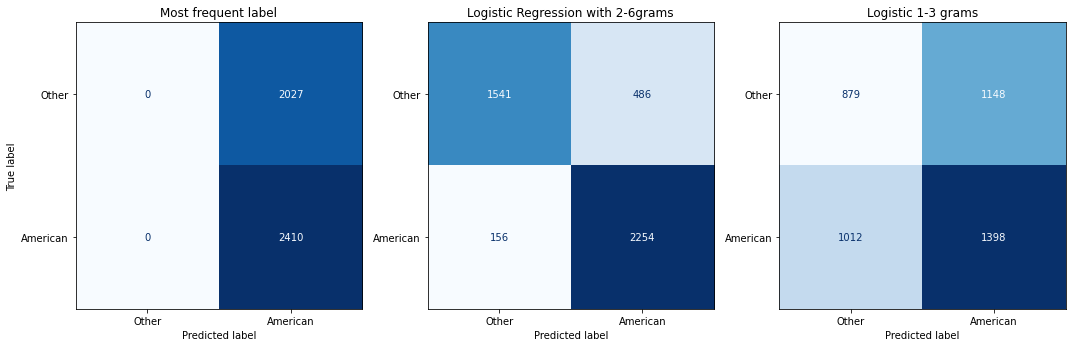

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
f, axes = plt.subplots(1, 3, figsize = (15, 5))

all_pred = {'Most frequent label':baseline1, 'Logistic Regression with 2-6grams':baseline2, 'Logistic 1-3 grams':predictions_lr}

for i, pred in enumerate(all_pred.items()):
    cm = confusion_matrix(y_test, pred[1], labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Other','American'])
    disp.plot(cmap=plt.cm.Blues, ax = axes[i])
    disp.ax_.set_title(pred[0])
    disp.im_.colorbar.remove()
    if i!=0:
        disp.ax_.set_ylabel('')
    plt.tight_layout()

### 6.7. Bootstrap sampling significance tests

This technique is employed to assess whether the observed difference in performance metrics, such as F1 score, between two systems is statistically significant. 

The code conducts resampling by creating multiple subsamples with replacement from the original dataset. For each subsample, it computes the performance scores of both systems and calculates the difference. The proportion of subsamples where the performance difference is significantly larger than the baseline difference determines the p-value. 

This method aids in understanding if the disparities observed in model performance are statistically meaningful or if they could occur by chance. The comparison is demonstrated by applying the bootstrap sampling to assess the significance of performance differences between most frequent label (baseline1) and logistic regression (baseline2) and a Convolutional Neural Network (CNN) classifier. The resulting p-values and corresponding histograms provide insights into the statistical significance of observed variations in model performance.

In [54]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

In [55]:
# comparing the baseline2 (logistic regression) with the LR
pvalue, delta = bootstrap_sample(baseline2, predictions_lr, y_test, samples=1000, score=f1_score, average='micro')
print(pvalue)

Base difference: 0.8553076402974983 vs. 0.513184584178499
0.0


The baseline Logistic Regression model (2-6grams) under performs the 1-3grams Logistic Regression model in terms of F1-micro score on the test set. This significant difference implies that, at least within the scope of this analysis, the Logistic Regression model is a more effective choice for the given classification task than the baseline as the obtained p-value of 0.0 indicates that the observed difference in F1-micro scores between the two models is statistically significant.

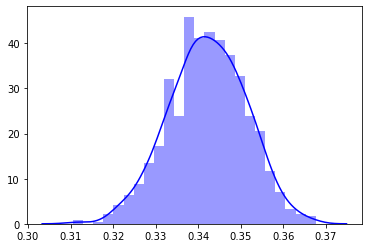

In [57]:
sns.distplot(delta, kde=True, color='blue')
plt.show()

In [58]:
# comparing the baseline1 (most frequent label) with the LR
pvalue1, delta1 = bootstrap_sample(baseline1, predictions_lr, y_test, samples=1000, score=f1_score, average='micro')
print(pvalue1)

Base difference: 0.5431597926526932 vs. 0.513184584178499
0.0


In comparing the baseline1 (Most Frequent Label predictor) with the Logistic Regression (LR) model, a bootstrap resampling analysis was conducted. The calculated p-value of 0.0 indicates that the observed difference in F1-micro scores between these two models is statistically significant.

The baseline1, represented by the Most Frequent Label predictor, achieved an F1-micro score of 0.5432, while the Logistic Regression model achieved a score of 0.5132. The extremely low p-value suggests that the observed discrepancy in performance is highly unlikely to occur by random chance.

Conclusion:
The statistical analysis reveals a significant difference in favor of the Most Frequent Label predictor over the Logistic Regression model in terms of F1-micro score on the test set. This implies that, in this specific context, the simplistic Most Frequent Label predictor performs better than the Logistic Regression model.

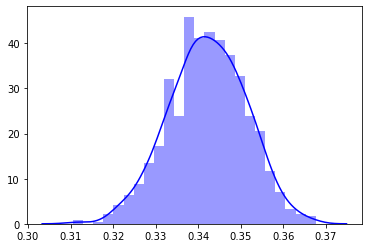

In [59]:
sns.distplot(delta, kde=True, color='blue')
plt.show()